Make image chips out of a set of image strips. The chip geometries are stored in a geojson file.

Each feature in the geojson must include a geometry in lat, long coordinates, a 'catid' property and a 'class' property.

Each image must be stored in the format catid.tif, where catid is the DG catalog id of that image.

Chips of a class are stored in a separate subdirectory for that class.

In [57]:
import os
import geojson
import subprocess
import numpy as np
import utm
import gdal
import cv2
import matplotlib.pyplot as plt
import glob

from os.path import join

%matplotlib inline

In [19]:
geojson_location = 'train.geojson'
image_directory = '.'
chip_directory = 'chips'
chip_classes = ['Boat', 'Other']
utm_projection = True               # if true, the images are in utm projection

import os

if not os.path.exists(chip_directory):
    os.makedirs(chip_directory)
    for class_name in chip_classes:
        os.makedirs(join(chip_directory, class_name))

In [20]:
def get_utm_info(image):
    "Return UTM info of image. Image must be in UTM projection."
    sample = gdal.Open(image)
    projection_info = sample.GetProjectionRef()
    where = projection_info.find('UTM zone') + 9
    utm_info = projection_info[where:where+3]
    utm_number, utm_letter = int(utm_info[0:2]), utm_info[2]
    return utm_number, utm_letter    

In [38]:
with open(geojson_location) as f:
    features = geojson.load(f)['features']

for i, feature in enumerate(features):

    if np.mod(i+1, 1000) == 0:
        print 'Chipping {} our of {}'.format(i+1, len(features))
    
    # get polygon bounding box
    polygon = feature['geometry']['coordinates'][0]
    xs, ys = zip(*polygon)
    ulx, lrx, uly, lry = min(xs), max(xs), max(ys), min(ys)

    # format gdal_translate command
    catid = feature['properties']['catid']
    image = join(image_directory, catid + '.tif')
    class_name = feature['properties']['class']
    
    # convert to utm coordinates if required
    if utm_projection:
        utm_number, utm_letter = get_utm_info(image)
        ulx, uly, utm_number_1, utm_letter_1 = utm.from_latlon(uly, ulx, force_zone_number=utm_number)
        lrx, lry, utm_number_2, utm_letter_2 = utm.from_latlon(lry, lrx, force_zone_number=utm_number)
    
    cmd = 'gdal_translate -eco -projwin {} {} {} {} {} {}'.format(ulx, 
                                                                  uly, 
                                                                  lrx, 
                                                                  lry, 
                                                                  image, 
                                                                  join(chip_directory, class_name, str(i+1) + '.tif'))
    try:
        subprocess.call(cmd, shell=True)
    except:
        print 'This command failed: ' + cmd 
        

Chipping 1000 our of 10000
Chipping 2000 our of 10000
Chipping 3000 our of 10000
Chipping 4000 our of 10000
Chipping 5000 our of 10000
Chipping 6000 our of 10000
Chipping 7000 our of 10000
Chipping 8000 our of 10000
Chipping 9000 our of 10000
Chipping 10000 our of 10000


Plot a chip. The 'uint8' setting is just in case the bit-depth is other than 8. The conversion from BGR to RGB is required because the image is read in B,G,R order when using opencv.

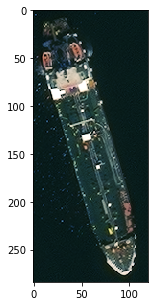

In [132]:
plt.figure(figsize=(5, 5))
img = cv2.imread(join(chip_directory, 'Boat', '2139.tif'))
plt.imshow(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_BGR2RGB))  

Get statistics on chip dimensions.

In [ ]:
dims = []

for chip in glob.glob(join(chip_directory, '*','*')):
    img = cv2.imread(chip)
    dims.append(img.shape)

ydims, xdims, zdims = zip(*dims)
print 'mean x: {}, std x: {}'.format(np.mean(xdims), np.std(xdims))
print 'mean y: {}, std y: {}'.format(np.mean(ydims), np.std(ydims))

In most cases, the input to neural networks is a square. If the chips are to be used to train/test a neural net, then they have to be converted to squares of a given side length, s.
The conversion implemented here is to set the length of the longest side of the chip to s and zero pad where necessary.
Note that the formatted chips are saved as png's. The geospatial metadata associated with each tif is lost.

In [135]:
# create directory and subdirectories for formatted chips
formatted_chip_directory = 'formatted_chips'

if not os.path.exists(formatted_chip_directory):
    os.makedirs(formatted_chip_directory)
    for class_name in chip_classes:
        os.makedirs(join(formatted_chip_directory, class_name))

s = 224            # formatted chip side

chips = glob.glob(join(chip_directory, '*','*'))

for i, chip in enumerate(chips):
    
    if np.mod(i+1, 1000) == 0:
        print 'Converting {} out of {} chips'.format(i+1, len(features))

    
    img = cv2.imread(chip)
    y, x, z = img.shape

    new_short = s * min(x,y) / max(x,y)
    pad_amount = s - new_short

    if x < y:
        new_dims = (s, new_short)
        p = ((0, 0), (0, pad_amount), (0, 0))   # the entry of each tuple is the amount of padding before start and after end of corresponding axis 
    else:
        new_dims = (new_short, s)
        p = ((0, pad_amount), (0, 0), (0, 0))

    resized_img = cv2.resize(img, (new_dims[1], new_dims[0]))     # the resize function accepts (number of columns) x (number of rows)
    formatted_img = np.pad(resized_img, p, 'constant', constant_values=0)
        
    # save as png
    cv2.imwrite(join(formatted_chip_directory, 
                     chip.split('/')[-2],
                     chip.split('/')[-1][:-3] + 'png'), 
                formatted_img)    

Converting 1000 out of 10000 chips
Converting 2000 out of 10000 chips
Converting 3000 out of 10000 chips
Converting 4000 out of 10000 chips
Converting 5000 out of 10000 chips
Converting 6000 out of 10000 chips
Converting 7000 out of 10000 chips
Converting 8000 out of 10000 chips
Converting 9000 out of 10000 chips
Converting 10000 out of 10000 chips


Plot the original chip and its formatted version.

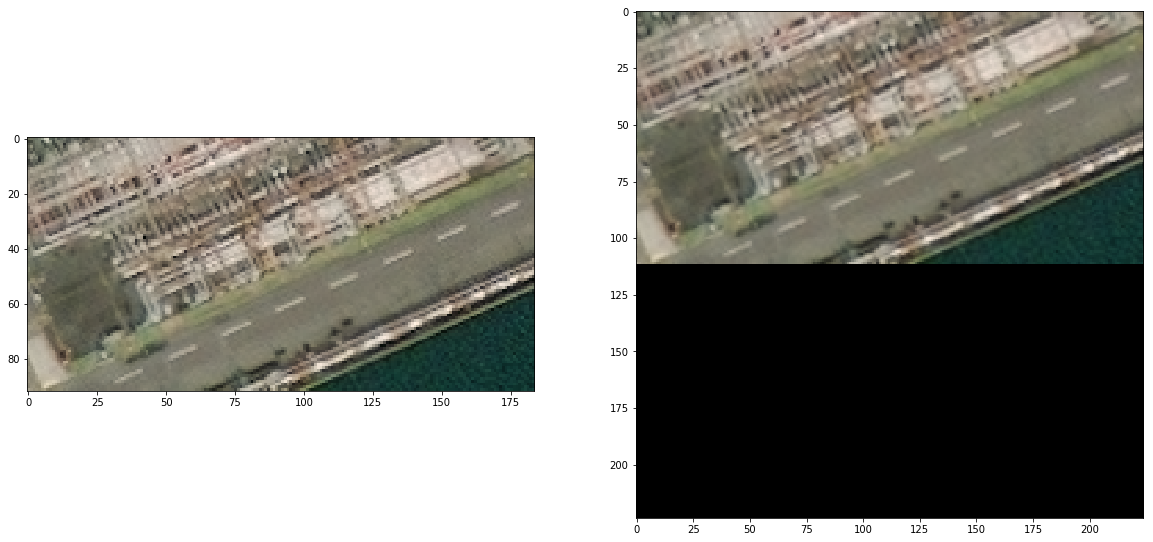

In [134]:
plt.figure(figsize=(20, 10))
img = cv2.imread(join(chip_directory, 'Other', '4608.tif'))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_BGR2RGB))
img = cv2.imread(join(formatted_chip_directory, 'Other', '4608.png'))
plt.subplot(122)
plt.imshow(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_BGR2RGB))